In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import syft as sy
import numpy as np
import torch as th
from syft import VirtualMachine
from pathlib import Path
from torchvision import datasets, transforms
from syft.core.plan.plan_builder import PLAN_BUILDER_VM, make_plan, build_plan_inputs, ROOT_CLIENT
from syft.lib.python.list import List
from matplotlib import pyplot as plt
from syft import logger
logger.remove()

# Dataset

In [3]:
from syft.util import get_root_data_path
mnist_path = get_root_data_path()

In [4]:
mnist_train = datasets.MNIST(str(mnist_path), train=True, download=True,
               transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))

mnist_test = datasets.MNIST((mnist_path), train=False, 
              transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))

In [5]:
train_loader = th.utils.data.DataLoader(mnist_train, batch_size=64*3, shuffle=True, pin_memory=True)
test_loader = th.utils.data.DataLoader(mnist_test, batch_size=1024, shuffle=True, pin_memory=True)

# Define Plan

obvious shortcommings:
- slice is not in the AST, so we cannot do for xs[0:64]
- nn.module is not serializable, so we cannot send it
- we are using syft.lib.python.list.List to create a sendable list of model params

In [6]:
class MLP(sy.Module):
    def __init__(self, torch_ref):
        super().__init__(torch_ref=torch_ref)
        self.l1 = self.torch_ref.nn.Linear(784, 100)
        self.a1 = self.torch_ref.nn.ReLU()
        self.l2 = self.torch_ref.nn.Linear(100, 10)
        
    def forward(self, x):
        x_reshaped = x.view(-1, 28 * 28)
        l1_out = self.a1(self.l1(x_reshaped))
        l2_out = self.l2(l1_out)
        return l2_out

In [9]:
def set_params(model, params):
    """happens outside of plan"""
    for p, p_new in zip(model.parameters(), params): p.data = p_new.data

In [10]:
def cross_entropy_loss(logits, targets, batch_size):
    norm_logits = logits - logits.max()
    log_probs = norm_logits - norm_logits.exp().sum(dim=1, keepdim=True).log()
    return -(targets * log_probs).sum() / batch_size

In [11]:
def sgd_step(model, lr=0.1):
    with ROOT_CLIENT.torch.no_grad():
        for p in model.parameters():
            p.data = p.data - lr * p.grad            
            p.grad = th.zeros_like(p.grad.get())

In [12]:
local_model = MLP(th)

In [14]:
@make_plan
def train(xs = th.rand([64*3, 1, 28, 28]), ys = th.randint(0, 10, [64*3, 10]),
          params = List(local_model.parameters()) ):
    model = local_model.send(ROOT_CLIENT)
    set_params(model, params)
    for i in range(1):
        indices = th.tensor(range(64*i, 64*(i+1)))
        x, y = xs.index_select(0, indices), ys.index_select(0, indices)
        out = model(x)
        loss = cross_entropy_loss(out, y, 64)
        loss.backward()
        sgd_step(model)
        
    return model.parameters()

In [1]:
# train.actions

In [2]:
# train.actions[:10]

# Run

In [25]:
alice_client = VirtualMachine(name="alice").get_client()
train_ptr = train.send(alice_client)

In [15]:
def test(test_loader, model):
    correct = []
    model.eval()
    for data, target in test_loader:
        output = model(data)
        _, pred = th.max(output, 1)
        correct.append(th.sum(np.squeeze(pred.eq(target.data.view_as(pred)))))
    acc = sum(correct) / len(test_loader.dataset)
    return acc

In [16]:
def show_predictions(test_loader, model, n=6):
    xs, ys = next(iter(test_loader))
    preds = model(xs).detach()
    
    fig, axs = plt.subplots(1, n, sharex='col', sharey='row', figsize=(16, 8))
    for i in range(n):
        ax = axs[i]
        ax.set_xticks([]),ax.set_yticks([])
        ax.set_xlabel(f"prediction: {np.argmax(preds[i])}, actual: {ys[i]}")
        ax.imshow(xs[i].reshape((28, 28)))


accuracy: 0.07


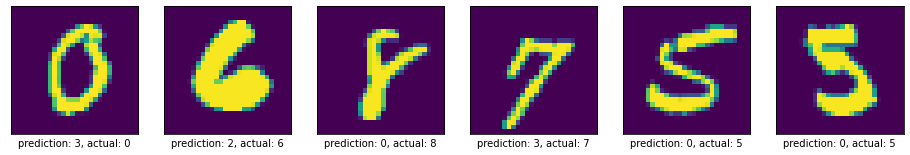

In [17]:
show_predictions(test_loader, local_model)
print(f"accuracy: {test(test_loader, local_model):.2F}")

## Train

In [18]:
for i, (x, y) in enumerate(train_loader):
    y = th.nn.functional.one_hot(y)
    res_ptr  = train_ptr(xs=x,ys=y, params=local_model.parameters())
    params, = res_ptr.get()
    set_params(local_model, params)

    if i%10 == 0:
        acc = test(test_loader, local_model)
        print(f"Iter: {i} Test accuracy: {acc:.2F}", flush=True)
    if i>100:
        break

Iter: 0 Test accuracy: 0.32
Iter: 10 Test accuracy: 0.67
Iter: 20 Test accuracy: 0.84
Iter: 30 Test accuracy: 0.82
Iter: 40 Test accuracy: 0.83
Iter: 50 Test accuracy: 0.85
Iter: 60 Test accuracy: 0.89
Iter: 70 Test accuracy: 0.89
Iter: 80 Test accuracy: 0.88
Iter: 90 Test accuracy: 0.88
Iter: 100 Test accuracy: 0.88


## Test

accuracy: 0.90


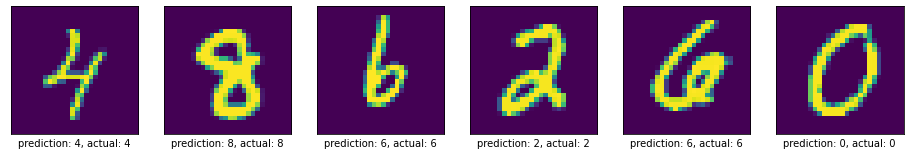

In [20]:
show_predictions(test_loader, local_model)
print(f"accuracy: {test(test_loader, local_model):.2F}")